cpu


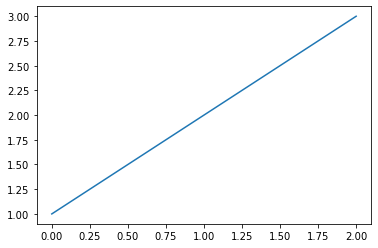

In [2]:
import importlib
from matplotlib import pyplot as plt
plt.plot([1,2,3])
from IPython.display import clear_output
import matplotlib
import numpy as np
import pandas as pd
import pdb
import time
from collections import deque
import torch
import cv2
from Environment.Env_new import RealExpEnv
from RL.sac import sac_agent, ReplayMemory, HerReplayMemory
from Environment.data_visualization import plot_graph, show_reset, show_done, show_step
from Environment.episode_memory import Episode_Memory
from Environment.get_atom_coordinate import atom_detection, blob_detection, get_atom_coordinate_nm
from skimage import morphology, measure
from Environment.createc_control import Createc_Controller
import glob
from collections import deque
matplotlib.rcParams['image.cmap'] = 'gray'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

succeed to connect
(128, 128)


"\ntemplate_path = 'template.png'\n#cv2.imwrite(template_path, template)\n"

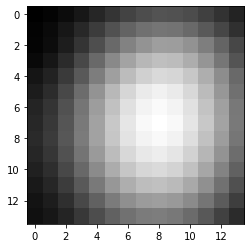

In [2]:
createc_controller = Createc_Controller(None, None, None, None)
img_forward = np.array(createc_controller.stm.scandata(1,4))
print(img_forward.shape)
top_left, w, h = (10,5), 15, 15
template = img_forward[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]
plt.imshow(template)

In [ ]:
#test offset extration
DAC_unit = 2**19
volt_unit = 10
Xgain = float(createc_controller.stm.getparam("GainX"))
Ygain = float(createc_controller.stm.getparam("GainY"))
Xpiezoconst = float(createc_controller.stm.getparam("Xpiezoconst"))
Ypiezoconst = float(createc_controller.stm.getparam("Ypiezoconst"))
x_nm = -0.1*Xpiezoconst*volt_unit*float(createc_controller.stm.getparam('OffsetX'))*Xgain/DAC_unit
y_nm = -0.1*Ypiezoconst*volt_unit*float(createc_controller.stm.getparam('OffsetY'))*Ygain/DAC_unit
print(x_nm, y_nm)

In [24]:
step_nm = 0.4
max_mvolt = 15 #min_mvolt = 0.5*max_mvolt
max_pcurrent_to_mvolt_ratio = 6E3 # min = 0.5*max
goal_nm  = 2
current_jump  = 3
pixel = 128

im_size_nm = 8.491

offset_nm = np.array([x_nm, y_nm])
manip_limit_nm = np.array([-19.5, -13.9, -37, -30.5]) #[left, right, up, down]
template_max_y = 25
scan_mV = 1000
max_len = 5
env = RealExpEnv(step_nm, max_mvolt, max_pcurrent_to_mvolt_ratio, goal_nm, 
                 template, current_jump, im_size_nm, offset_nm, manip_limit_nm, pixel, 
                 template_max_y, scan_mV, max_len, 'atom_move_detector.pth', bottom=False, random_scan_rate = 0)


gain: 10.0
191.53506700000003 -13.581448
-0.09 -0.138
191.62506700000003 -13.443448
succeed to connect


In [4]:
# ONLY RE-RUN if WANT TO RESET the AGENT
batch_size= 64
LEARNING_RATE = 0.0003
replay_size=1000000

agent = sac_agent(num_inputs = 4, num_actions = 6, action_space = None, device=device, hidden_size=256, lr=LEARNING_RATE,
                 gamma=0.9, tau=0.005, alpha=1)
agent.critic.load_state_dict(torch.load('{}/_critic_{}.pth'.format(folder_name,60)))
agent.policy.load_state_dict(torch.load('{}/_policy_{}.pth'.format(folder_name,60)))
agent.alpha = torch.load(''{}/_alpha_{}.pth'.format(folder_name,i_episode))
memory = HerReplayMemory(replay_size, env)

In [10]:
episode_memory = Episode_Memory()
folder_name = 'C:/LocalUserData/User-data/phys-asp-lab/auto_manipulation/evaluation_0'

In [ ]:
episode_rewards, alphas, precisions, episode_lengths = [], [], [], []
avg_episode_rewards, avg_alphas, avg_precisions, avg_episode_lengths = [], [], [], []

In [ ]:
def sac_train(max_steps, num_episodes = 50, episode_start = 0):
    for i_episode in range(episode_start,episode_start+num_episodes):
        print('Episode:', i_episode)
        eta_t = np.minimum(eta_0 + (eta_T - eta_0)*(i_episode/n_interactions), eta_T)
        episode_reward, episode_steps = 0, 0
        done = False
        state, info = env.reset(update_conv_net=False)
        show_reset(env.img_info, env.atom_start_absolute_nm, env.destination_absolute_nm,
                   env.template_nm, env.template_wh)
        episode_memory.update_memory_reset(env.img_info, i_episode, info)
        
        for step in range(max_steps):
            print('step:', step)
            action = agent.select_action(state, eval=True)
            old_atom_nm = env.atom_absolute_nm
            next_state, reward, done, info = env.step(action)
            print('reward', reward)
            
            episode_steps+=1
            episode_reward+=reward
            mask = float(not done)
            memory.push(state,action,reward,next_state,mask)
            episode_memory.update_memory_step(state, action, next_state, reward, done, info)
            show_step(env.img_info, info['start_nm']+old_atom_nm, info['end_nm']+old_atom_nm,
                        env.atom_absolute_nm, env.atom_start_absolute_nm, 
                        env.destination_absolute_nm, action[4]*env.max_mvolt, 
                        action[5]*env.max_pcurrent_to_mvolt_ratio*action[4]*env.max_mvolt, 
                        env.template_nm, env.template_wh)
            print('Precision:', env.dist_destination)
            if done:
                episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, env.atom_relative_nm)
                episode_memory.save_memory(folder_name)
                
                atom_to_start = env.atom_relative_nm - env.atom_start_relative_nm
                print('Episode reward:', episode_reward)
                
                break
            else:                
                state=next_state
        
        episode_rewards.append(episode_reward)
        alphas.append(agent.alpha.item())
        precisions.append(env.dist_destination)
        episode_lengths.append(episode_steps)
        avg_episode_rewards.append(np.mean(episode_rewards[-min(100,len(episode_rewards)):]))
        avg_alphas.append(np.mean(alphas[-min(100, len(alphas)):]))
        avg_precisions.append(np.mean(precisions[-min(100, len(precisions)):]))
        avg_episode_lengths.append(np.mean(episode_lengths[-min(100, len(episode_lengths)):]))
        
        if (i_episode+1)%2==0:
            plot_graph(episode_rewards, precisions, alphas, episode_lengths,
                      avg_episode_rewards, avg_alphas, avg_precisions, avg_episode_lengths)
            

In [28]:
env.atom_absolute_nm = None

Episode: 100
goal_nm: 0.38093301952721753


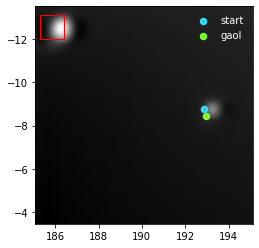

old value: 6.295669330378839
step: 0
96 60 108 76
The scan will take 19.7 seconds
atom moves by: 0.5191303311870532
value: 9.452185681584941
2.956516351206103


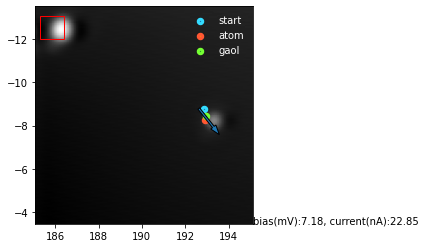

template_nm [185.32143156 -13.06914547]
step: 1
98 70 108 74
The scan will take 19.7 seconds
atom moves by: 0.4438440579492429
value: 9.996853887744578
0.34466820615963734


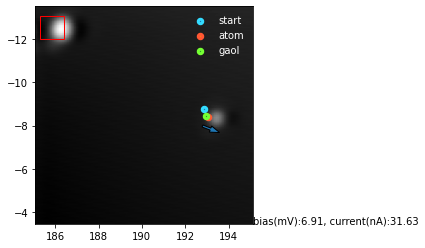

template_nm [185.32143156 -13.06914547]
atom moved by: 0.4088653491913002
Episode reward: 3.3011845573657403


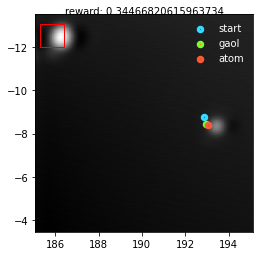

tensor([0.1171], device='cuda:0')


In [36]:
sac_train(max_steps=max_len, episode_start = 100,num_episodes = 1)

0.2158000324064272


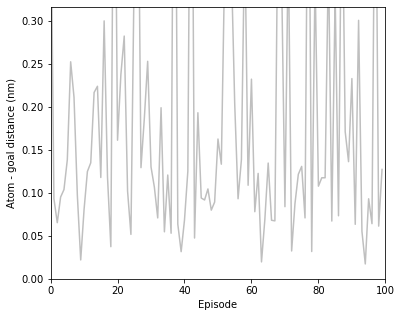

In [30]:
atom_destination_distance = []
angle = []
for i, np_name in enumerate(glob.glob('training_4/eval/*.npy')):
    try:
        data = np.load(np_name,allow_pickle=True).item()
        start_relative = data['episode_start_info']['info']['start_absolute_nm']
        destination_relative = data['episode_start_info']['info']['goal_absolute_nm']
        atom_relative = data['episode_end_info']['atom_absolute_nm']
        atom_destination_distance.append(np.linalg.norm(atom_relative - destination_relative))
        angle.append(np.arctan2((destination_relative-start_relative)[1],(destination_relative-start_relative)[0]))
    except:
        pass
n = 100
plt.subplots(figsize=(6,5))
avg_atom_destination_distance = np.convolve(atom_destination_distance, np.ones(n), mode='valid')/n
plt.plot(atom_destination_distance, color='gray', alpha=0.5)

plt.plot(avg_atom_destination_distance, linewidth=3, color='#B85C38')
plt.xlim([0,len(atom_destination_distance)])
plt.ylim([0,np.max(avg_atom_destination_distance)+0.1])
plt.xlabel('Episode')
plt.ylabel('Atom - goal distance (nm)')
print(avg_atom_destination_distance[-1])

In [35]:
len(atom_destination_distance)

100

78
64


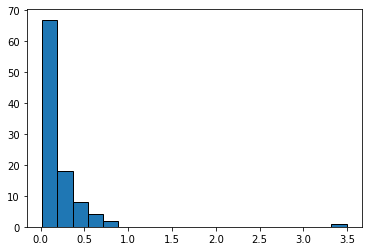

In [31]:
plt.hist(atom_destination_distance[-100:], bins=20, cumulative=False, edgecolor='black')
print(np.sum(np.array(atom_destination_distance[-100:])<0.28))
print(np.sum(np.array(atom_destination_distance[-100:])<0.1616))

Text(0, 0.5, 'Episode reward')

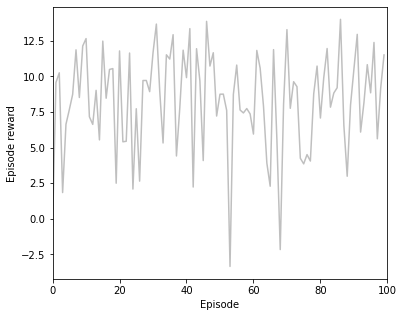

In [34]:
episode_rewards = []
for i, np_name in enumerate(glob.glob('training_4/eval/*.npy')):
    try:
        data = np.load(np_name,allow_pickle=True).item()
        episode_rewards.append(np.sum(data['transitions']['reward']))
    except:
        pass
avg_episode_rewards = np.convolve(episode_rewards, np.ones(n), mode='valid')/n
plt.subplots(figsize=(6,5))

plt.plot(episode_rewards, color='gray', alpha=0.5)
plt.plot(avg_episode_rewards, linewidth=3, color='#142F43')

plt.xlim([0,len(episode_rewards)])
#plt.ylim([np.min(avg_episode_rewards)-1,np.max(avg_episode_rewards)+1])
plt.xlabel('Episode')
plt.ylabel('Episode reward')